<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/CNN_LRP_project_DST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Layer wise relevance propagation

## Layer wise Relevance Propagation
Layer-wise relevance propagation (LRP) is a backward explanation technique for neural networks. A forward pass is first computed and the activations $ a_j $, are stored at each layer. Then, instead of backpropagating gradients, LRP backpropagates relevance values $ R $, starting from the output neuron. A positive relevance indicates that a neuron contributes in favour of the prediction, whereas negative relevance indicates contribution against the prediction


If $ j $ and $ k $ are neurons at two consecutive layers of the neural network, such that $ j $ is in the lower layer (closest to the input) and $ k$ is the upper layer (closest to the output). We say the the forwards contribution from $ j \rightarrow k $ is $ z_{jk} = a_j w_{jk} $. Where $ a_j $ is the activation at neuron $ j $  such that $ a_k = \max(0, \sum _{0,j} a_jw_{jk} )$ and $ w_{jk} $ is the weight. We set $ a_0 = 1 $ and $ w_{0k} $ to be the neuron bias.



We define the propagating relevance score at a given layer onto the neurons of the lower layer to be
\begin{equation}
    R_j = \sum _k \frac{z_{jk}}{\sum_j z_{jk} } R_k
\end{equation}





This satisfies the layer-wise conservation property $ \sum _j R_j = \sum _k R_k $ and consequently the global conservation property $ \sum _i R_i = f(x) $

We can see the LRP procedure in the figure below.

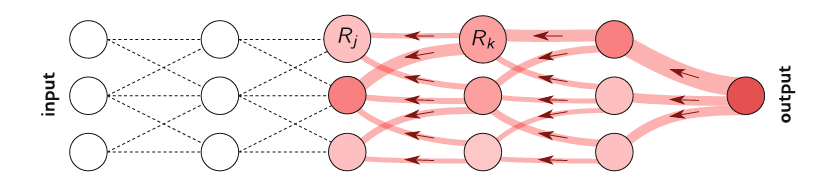
### Propagation rules

We will include three propagation rules in the implementation of LRP, they are the following.

Basic Rule, LRP-0, which uses the raw contributions with no stabilisations

$ R_j = \sum _k \frac{a_j w_{jk} }{\sum_{0,j}a_j w_{jk} } R_k $


Epsilon Rule, LPR-$\epsilon$

$ R_j = \sum _k \frac{a_j w_{jk} }{\epsilon + \sum_{0,j}a_j w_{jk} } R_k $

$ \epsilon $ prevents division by small denominators. It absorbs some of the relevance when the contributions of the activation $ k $ are weak or contradictory.


Gamma Rule, LRP-$\gamma$

$ R_j = \sum _k \frac{a_j ( w_{jk} + \gamma w_{jk}^+) }{\sum_{0,j}a_j ( w_{jk} + \gamma w_{jk}^+) } R_k $

This favors the effect of the positive contributions, and $ \gamma $ controls how much is favoured. As $ \gamma $ increases the negative contributions start to disappear.


We will use LRP-0 for the upper layers since the activations are stable and linear.
In the middle layer there are more noise and so using LRP-$\epsilon $ will filter the most accurate factors.
In the lower layer we will use LRP-$\gamma $ as it spreads the relevance uniformly across the features.




### Implementing LRP


We will consider a general rule:
\begin{equation}
     R_j = \sum _k \frac{a_j \rho (w_{jk}) }{\epsilon + \sum_{0,j}a_j \rho ( w_{jk}) } R_k
\end{equation}

And the computation can be broken down into the following steps:

\[
\begin{array}{ll}
\forall k:\quad z_k = \epsilon + \sum_{j} a_j \cdot \rho(w_{jk})
    & \text{(forward pass)} \\[6pt]
\forall k:\quad s_k = \frac{R_k}{z_k}
    & \text{(element-wise division)} \\[6pt]
\forall j:\quad c_j = \sum_{k} \rho(w_{jk}) \cdot s_k
    & \text{(backward pass)} \\[6pt]
\forall j:\quad R_j = a_j \cdot c_j
    & \text{(element-wise product)}
\end{array}
\]

We can also express $ c_j $ as the gradient so
$ c_j = [ \nabla ( \sum_k z_k (a) \dot s_k )]_j $.




implementing this rule in code gives us:


\begin{verbatim}
def relprop(a, layer, R):
    z = epsilon + rho(layer).forward(a)
    s = R / (z + 1e-9)
    (z * s.data).sum().backward()
    c = a.grad
    R = a * c
    return R
\end{verbatim}


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/DST assessment 2/brain tumor dataset.zip" -d "/content/data"

Archive:  /content/drive/MyDrive/DST assessment 2/brain tumor dataset.zip
  inflating: /content/data/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/data/Test

In [ ]:

!ls /content/data

Testing  Training


In [ ]:

import os
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")

Loaded image: /content/data/Training/meningioma_tumor/m1(39).jpg


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

In [ ]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
train_dataset.classes


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
from collections import Counter

counter = Counter([label for _, label in test_dataset])
print(counter)

# If you want class names
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
for idx, count in counter.items():
    print(idx_to_class[idx], ":", count)


Counter({1: 115, 2: 105, 0: 100, 3: 74})
glioma_tumor : 100
meningioma_tumor : 115
no_tumor : 105
pituitary_tumor : 74


In [ ]:

images, labels = next(iter(test_loader))
print(images.shape, labels.shape)


torch.Size([32, 3, 224, 224]) torch.Size([32])


(np.float64(-0.5), np.float64(1809.5), np.float64(453.5), np.float64(-0.5))

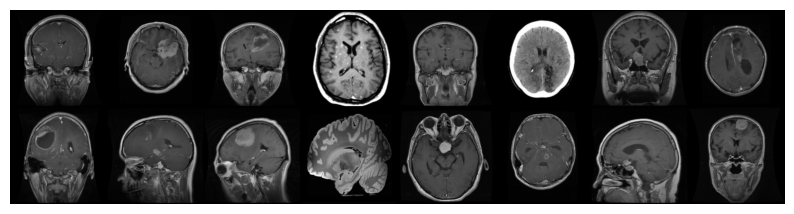

In [ ]:

import matplotlib.pyplot as plt
import torchvision

plt.figure(figsize=(10,10))
plt.imshow(torchvision.utils.make_grid(images[:16]).permute(1,2,0))
plt.axis("off")


In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(), #applies non linearity
            nn.MaxPool2d(2), #reduce spatial size and keep important features

            nn.Conv2d(16, 32, 3, padding=1), #16 features to 32 outputs
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(), #converrtr to 1D vector
            nn.Linear(32 * 56 * 56, 64), #convetrs map to 64 neurons
            nn.ReLU(),
            nn.Linear(64, len(train_dataset.classes)), #64 goes to 4 tumpr classes
        )

    def forward(self, x): #define input flor through network
        x = self.conv(x)
        return self.fc(x)




In [ ]:
import torchvision.models as models
import torch.nn as nn


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#criterion = torch.nn.CrossEntropyLoss() #
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


In [ ]:
model = SimpleCNN()
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() #
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5  # increase later

for epoch in range(epochs):
    model.train() #into trianing mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) #puts MRI j
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() #wher emodel learns tumour features

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total * 100
    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {running_loss:.4f}  Train Acc: {train_acc:.2f}%")


Epoch [1/5]  Loss: 107.3889  Train Acc: 45.85%
Epoch [2/5]  Loss: 82.5216  Train Acc: 58.89%
Epoch [3/5]  Loss: 62.8877  Train Acc: 71.39%
Epoch [4/5]  Loss: 57.1690  Train Acc: 73.73%
Epoch [5/5]  Loss: 50.7814  Train Acc: 77.14%



Image 0
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


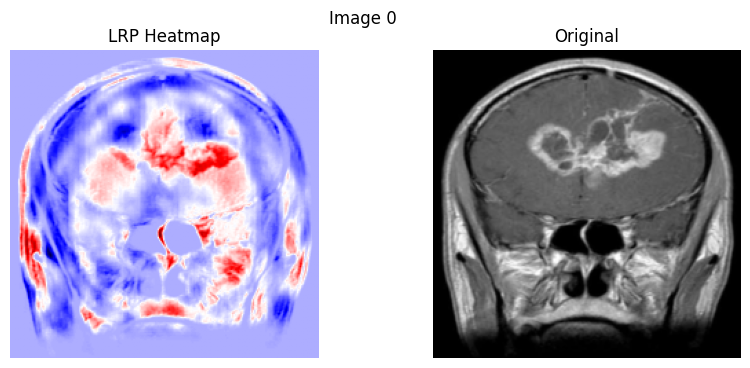


Image 1
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


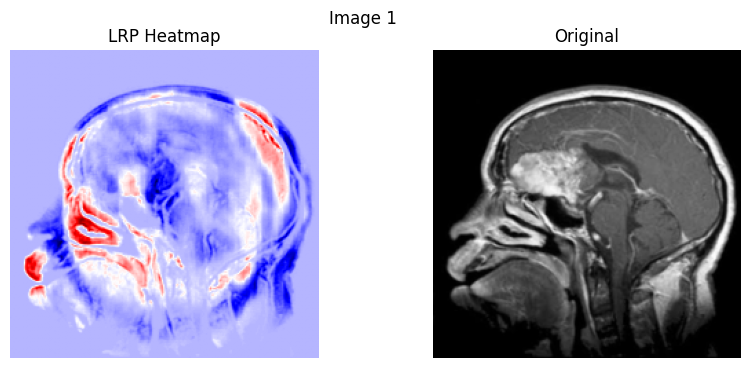


Image 2
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False



Image 3
True class: glioma_tumor
Predicted : meningioma_tumor
Correct?  : False


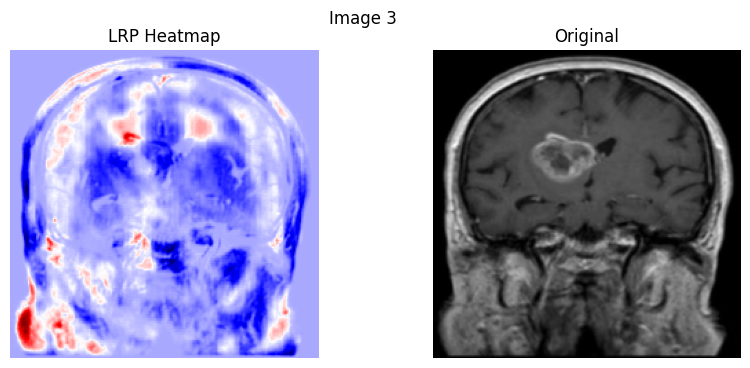


Image 4
True class: glioma_tumor
Predicted : meningioma_tumor
Correct?  : False


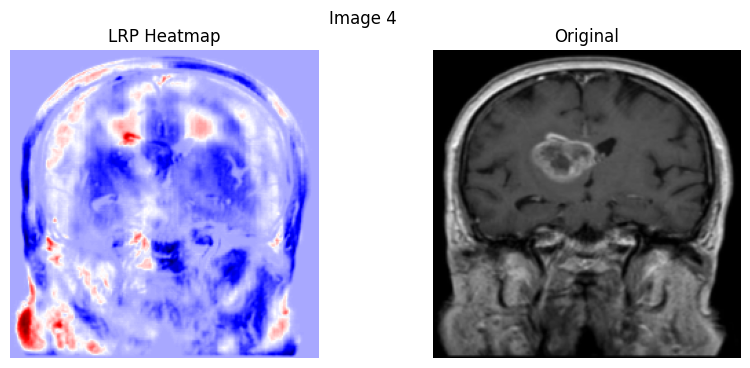


Image 5
True class: glioma_tumor
Predicted : meningioma_tumor
Correct?  : False


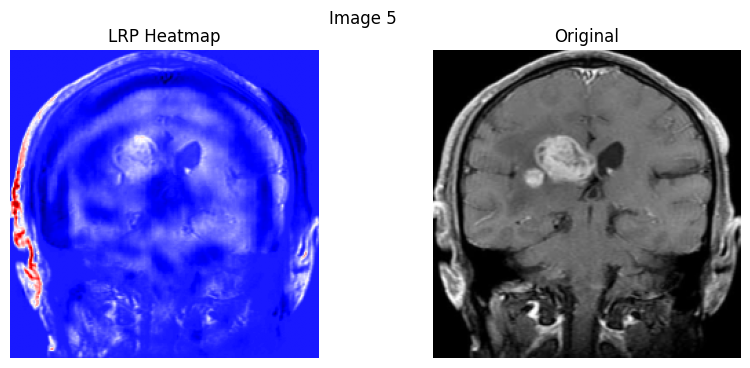


Image 6
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


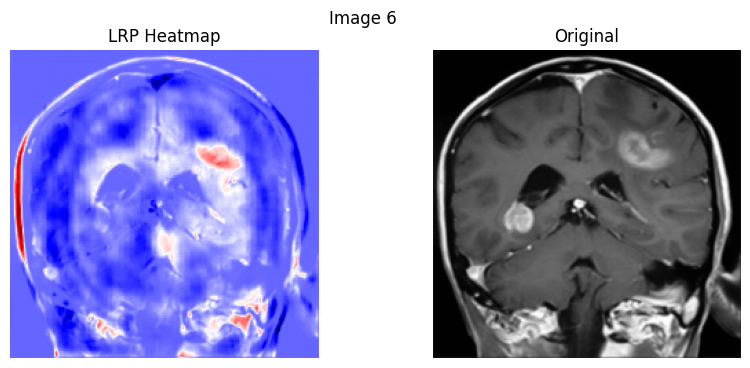


Image 7
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


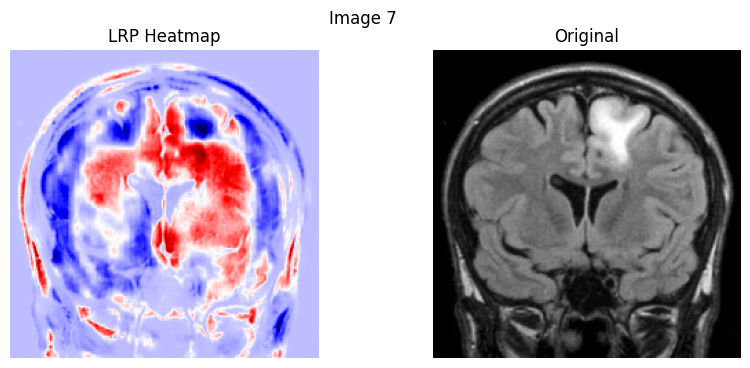


Image 8
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


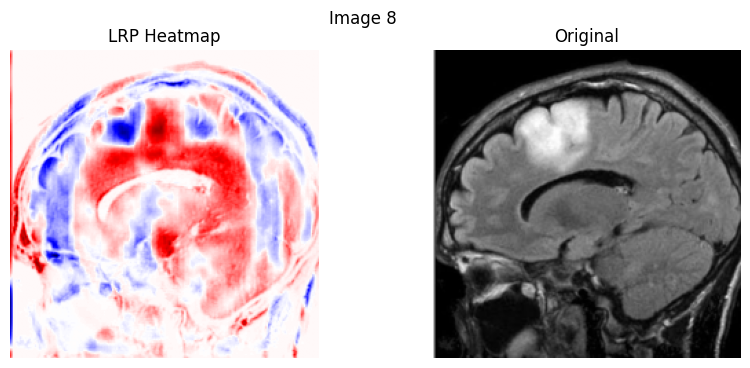


Image 9
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False



Image 10
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


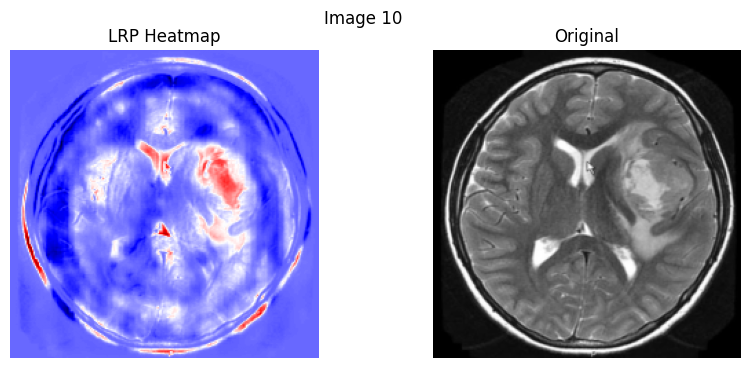


Image 11
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


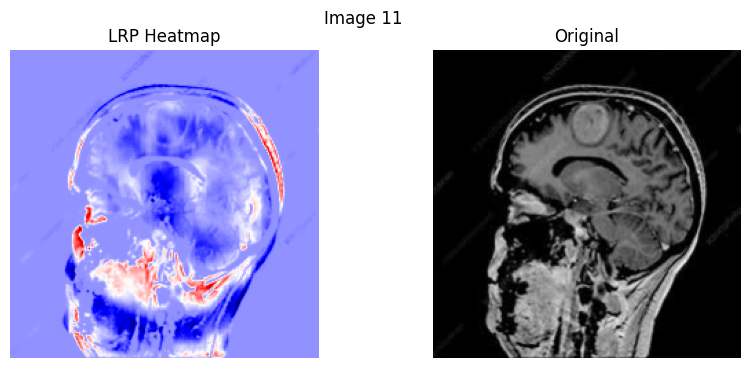


Image 12
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False



Image 13
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


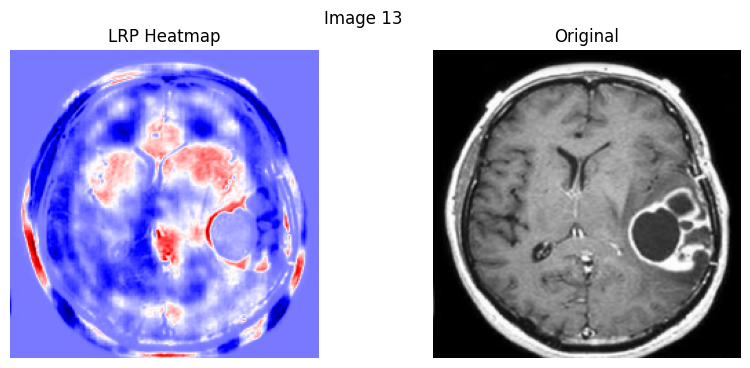


Image 14
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


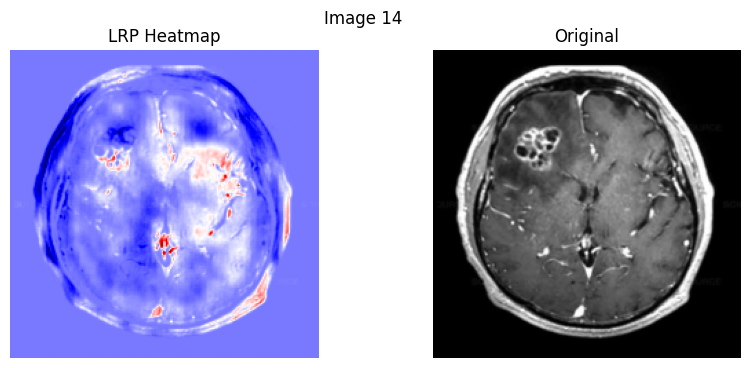


Image 15
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


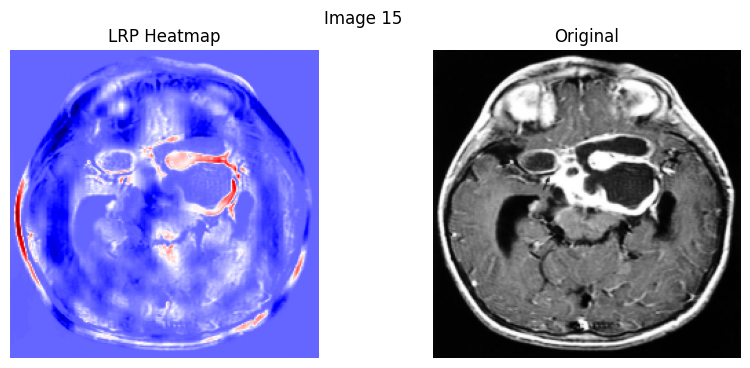


Image 16
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False



Image 17
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


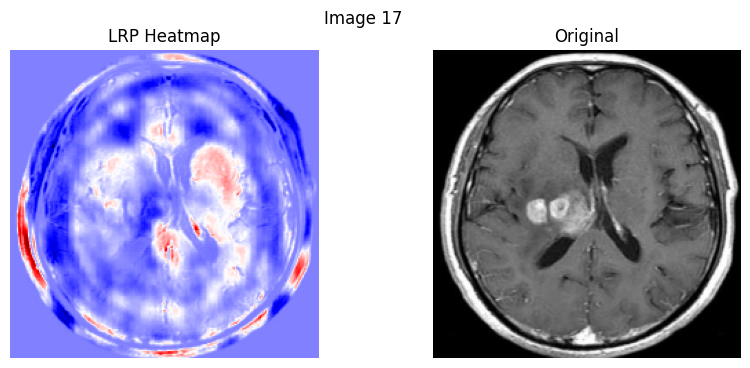


Image 18
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


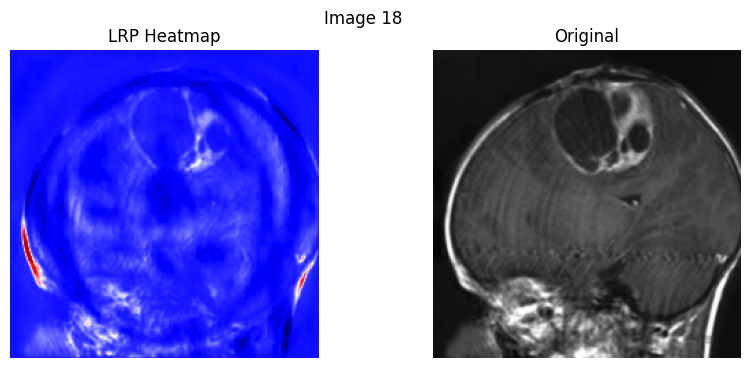


Image 19
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


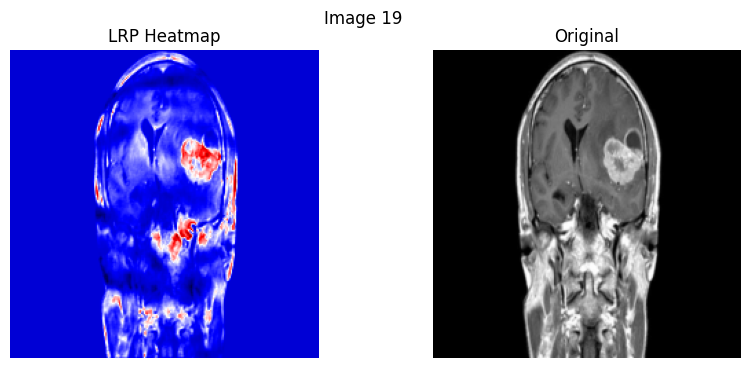


Image 20
True class: glioma_tumor
Predicted : meningioma_tumor
Correct?  : False


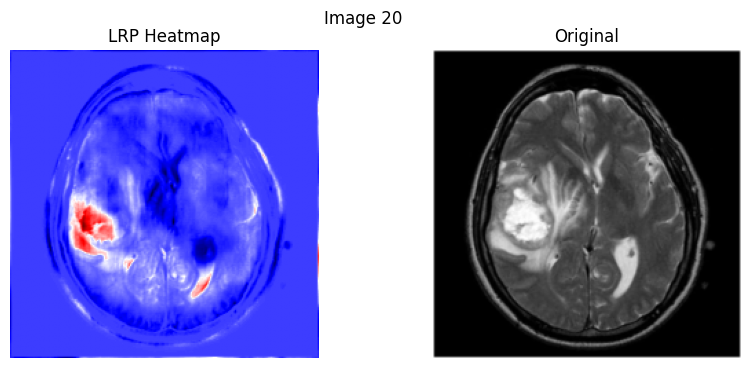


Image 21
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


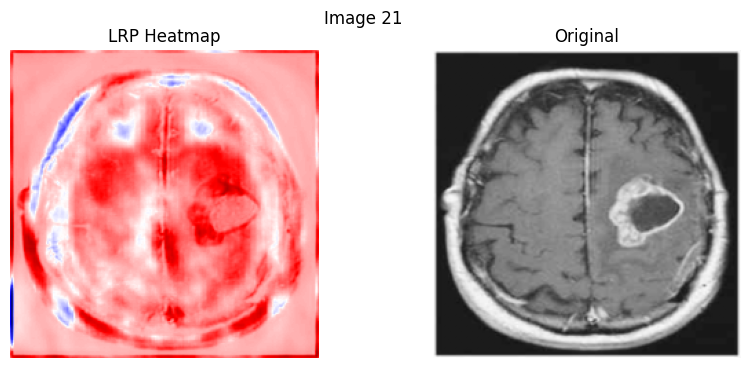


Image 22
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


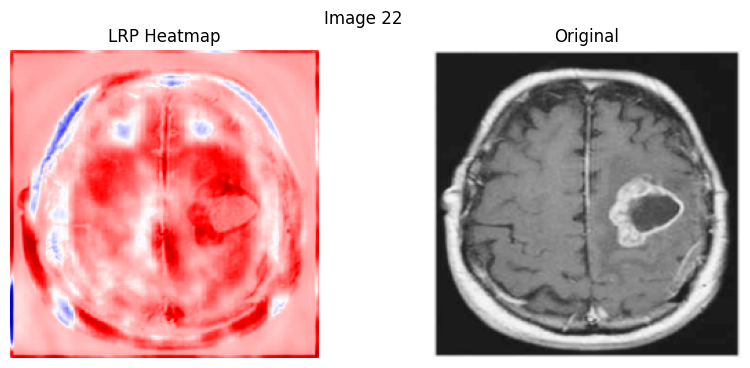


Image 23
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False



Image 24
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


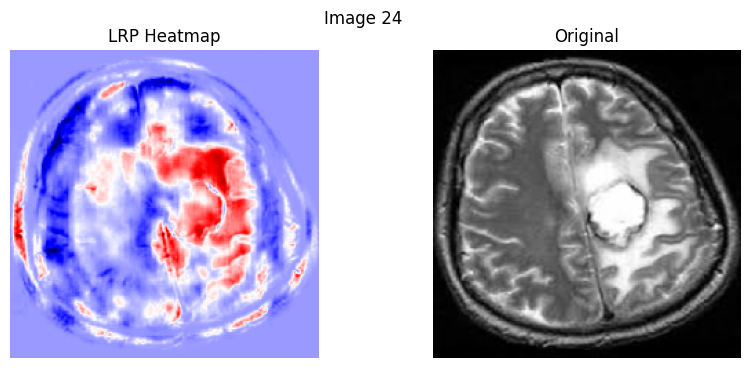


Image 25
True class: glioma_tumor
Predicted : meningioma_tumor
Correct?  : False


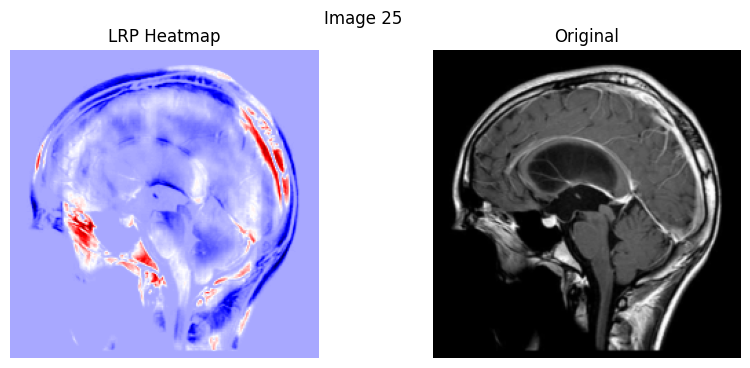


Image 26
True class: glioma_tumor
Predicted : meningioma_tumor
Correct?  : False



Image 27
True class: glioma_tumor
Predicted : glioma_tumor
Correct?  : True



Image 28
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


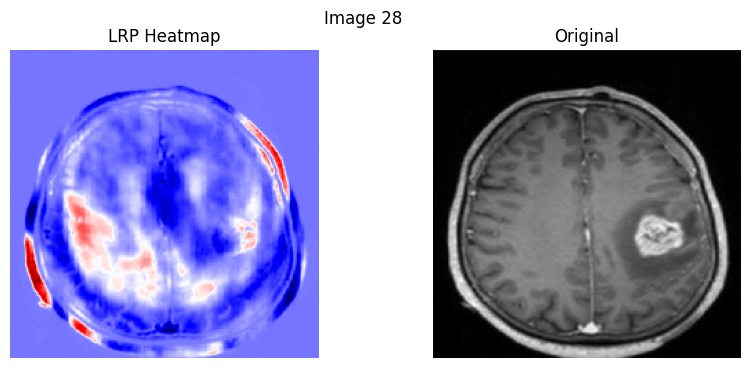


Image 29
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


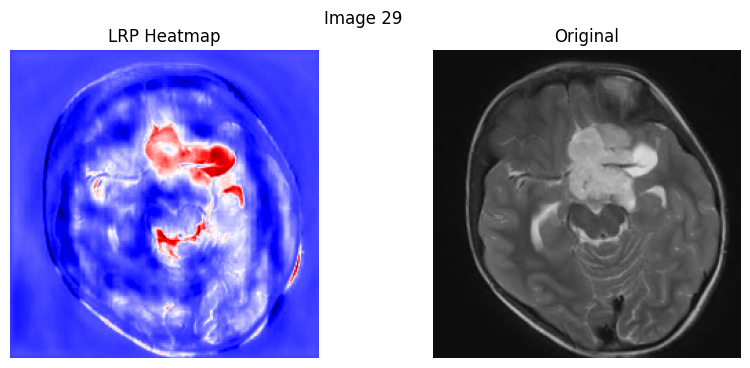


Image 30
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False



Image 31
True class: glioma_tumor
Predicted : no_tumor
Correct?  : False


In [ ]:
import torch.nn as nn

def get_simplecnn_layers(model):
    layers = []

    # Conv part
    for l in model.conv:
        layers.append(l)

    # FC part
    for l in model.fc:
        layers.append(l)

    return layers
import copy

def new_layer(layer, g):
    """Clone a layer and pass its parameters through function g."""
    layer = copy.deepcopy(layer)
    try:
        layer.weight = nn.Parameter(g(layer.weight))
    except AttributeError:
        pass
    try:
        layer.bias = nn.Parameter(g(layer.bias))
    except AttributeError:
        pass
    return layer

def apply_lrp_simplecnn(model, image):
    original_layers = get_simplecnn_layers(model)

    # Create a modified layers list for LRP: replace MaxPool2d with AvgPool2d
    lrp_layers = []
    for l in original_layers:
        if isinstance(l, nn.MaxPool2d):
            # Ensure attributes match for correct AvgPool2d creation
            lrp_layers.append(nn.AvgPool2d(
                kernel_size=l.kernel_size,
                stride=l.stride,
                padding=l.padding,
                ceil_mode=l.ceil_mode if hasattr(l, 'ceil_mode') else False
            ))
        else:
            lrp_layers.append(l)

    # ---- Step 1: forward: store activations ----
    x = image.unsqueeze(0)
    activations = [x]

    for layer in lrp_layers: # Use the modified layers here
        x = layer(x)
        activations.append(x)

    # ---- Step 2: One-hot output ----
    output = activations[-1].detach()
    max_idx = torch.argmax(output)

    one_hot = torch.zeros_like(output)
    one_hot[0, max_idx] = output[0, max_idx]     # keep magnitude

    relevances = [None] * len(activations)
    relevances[-1] = one_hot

    # ---- Step 3: Backward relevance propagation ----
    for i in range(len(lrp_layers)-1, -1, -1): # Iterate over lrp_layers

        layer = lrp_layers[i] # Use lrp_layers here

        # Special handling for nn.Flatten: reshape relevance
        if isinstance(layer, nn.Flatten):
            # Relevance for the input to Flatten layer (relevances[i])
            # should be relevances[i+1] (output of Flatten) reshaped
            # to match activations[i] (input to Flatten).
            prev_activation_shape = activations[i].shape
            relevances[i] = relevances[i+1].reshape(prev_activation_shape)
            continue # Already handled, move to next layer

        a = activations[i].clone().detach().requires_grad_(True)
        r = relevances[i+1] # This `r` is the relevance of the output of `layer`

        # Choose LRP rule by layer depth
        # Also include AvgPool2d in this check now
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear) or isinstance(layer, nn.AvgPool2d):

            # LRP-gamma for first 2 conv layers (indices 0, 1) and first MaxPool (index 2)
            # which is now AvgPool. So <= 2 is layers 0,1,2
            if i <= 2:
                rho = lambda p: p + 0.25*p.clamp(min=0)
                incr = lambda z: z + 1e-9

            # LRP-epsilon for mid layers
            # This applies to: Conv2, ReLU2, AvgPool2, Linear1.
            elif i < len(lrp_layers)-2:
                rho = lambda p: p
                incr = lambda z: z + 1e-6

            # LRP-0 for last linear layer and last ReLU
            else: # i >= 8
                rho = lambda p: p
                incr = lambda z: z + 1e-9

            z = new_layer(layer, rho)(a)
            z = incr(z)

            s = (r / z).data
            (z * s).sum().backward()

            c = a.grad
            relevances[i] = (a * c)

        else:
            # This 'else' block will now only be hit by nn.ReLU layers
            # as Flatten and MaxPool2d are handled explicitly.
            # For ReLU, relevance is passed unchanged, which is correct.
            relevances[i] = relevances[i+1]

    return relevances[0]

# %%
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

N = 32
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

model.eval()
# ------------------------------
#   Compute Test Accuracy & Loss
# ------------------------------
# criterion = nn.CrossEntropyLoss()
# model.eval()

# test_loss = 0.0
# correct = 0
# total = 0

# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         test_loss += loss.item() * images.size(0)

#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

# test_loss /= total
# test_accuracy = correct / total * 100

# print("====================================")
# print(f"Test Loss:     {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.2f}%")
# print("====================================")


for i in range(N):
    img = inputs[i].to(device)

    R = apply_lrp_simplecnn(model, img)
    R = R.permute(0,2,3,1).detach().cpu().numpy()[0]
    R = np.interp(R, (R.min(), R.max()), (0,1))

    # ---- Step 2: Ground truth label ----
    pred_label = list(test_dataset.class_to_idx.keys())[
        list(test_dataset.class_to_idx.values()).index(labels[i])
    ]

    # idx_to_class = {v:k for k,v in test_dataset.class_to_idx.items()}
    # true_class_name = idx_to_class[labels[i].item()]
    # pred_class_name = idx_to_class[predicted.item()]


    print(f"\nImage {i}")
    #print("Groundtruth:", pred_label)

    # ---- Step 3: Check model prediction ----
    with torch.no_grad(): # Ensure no gradient calculation for inference
        output = model(img.unsqueeze(0))
        _, predicted = torch.max(output, 1)
    true_label = labels[i].item()
    pred_label = predicted.item()

    print("True class:", idx_to_class[true_label])
    print("Predicted :", idx_to_class[pred_label])
    print("Correct?  :", true_label == pred_label)

    plt.figure(figsize=(10,4))
    plt.suptitle(f"Image {i}")

    plt.subplot(1,2,1)
    plt.title("LRP Heatmap")
    plt.imshow(R[:,:,0], cmap='seismic')
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Original")
    plt.imshow(inputs[i].permute(1,2,0).cpu().numpy())
    plt.axis("off")

    plt.show()

True


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 84.7MB/s]


tensor(1.4728, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3699, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3359, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2437, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4176, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3846, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3240, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3759, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1721, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3679, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1766, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1454, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2390, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1938, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1841, device='cuda:0', grad_fn=

/tmp/ipython-input-1106864376.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  activations[-1] = torch.FloatTensor([one_hot_output]).to(device)
/tmp/ipython-input-1106864376.py:176: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  activations[-1] = torch.FloatTensor([one_hot_output]).to(device)


True class: meningioma_tumor

Image 0
Groundtruth: meningioma_tumor
Correctly classified? True


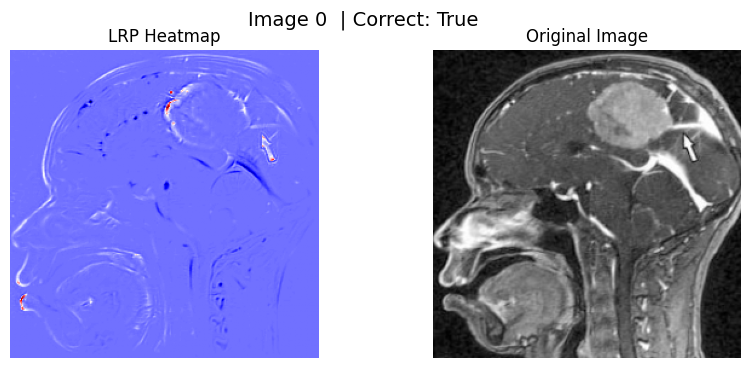

True class: glioma_tumor

Image 1
Groundtruth: glioma_tumor
Correctly classified? False


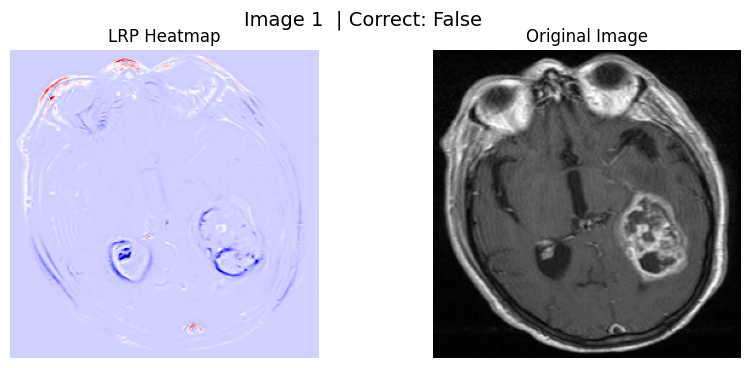

True class: pituitary_tumor

Image 2
Groundtruth: pituitary_tumor
Correctly classified? True


True class: no_tumor

Image 3
Groundtruth: no_tumor
Correctly classified? True


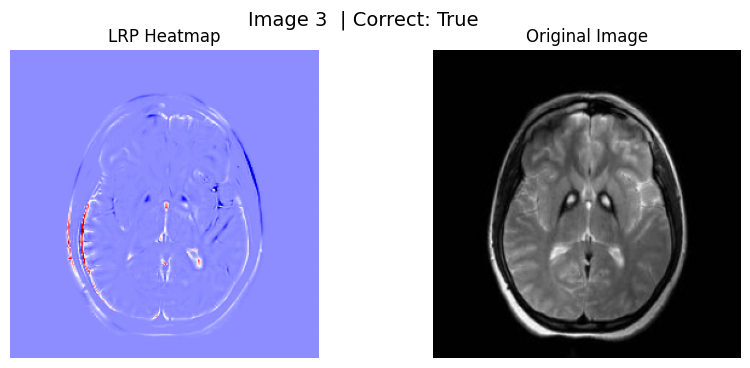

True class: no_tumor

Image 4
Groundtruth: no_tumor
Correctly classified? True


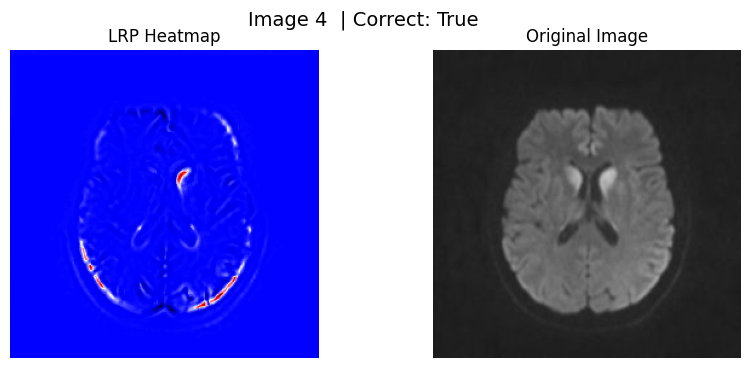

True class: glioma_tumor

Image 5
Groundtruth: glioma_tumor
Correctly classified? False


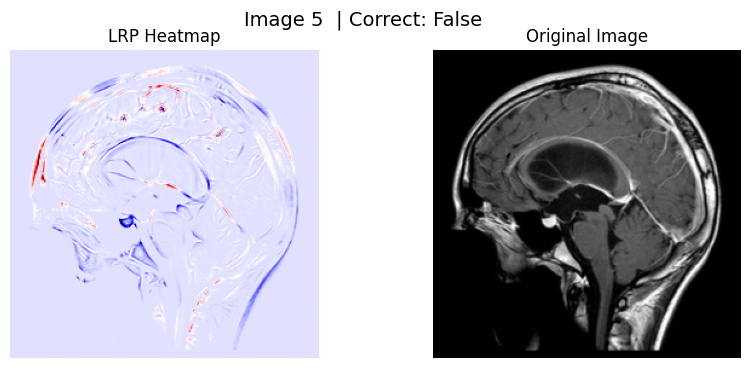

True class: meningioma_tumor

Image 6
Groundtruth: meningioma_tumor
Correctly classified? True


TypeError: not a sequence

In [ ]:
# %% Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd

# Set GPU device
print(torch.cuda.is_available())
device = torch.device("cuda:0")


# %% Load data
TRAIN_ROOT = "/content/data/Training"
TEST_ROOT = "/content/data/Testing"
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)
test_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)


# %% Building the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        # Replace output layer according to our problem
        in_feats = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_feats, 4)

    def forward(self, x):
        x = self.vgg16(x)
        return x

model2 = CNNModel()
model2.to(device)
model2

# %% Prepare data for pretrained model
train_dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)

test_dataset = torchvision.datasets.ImageFolder(
        root=TEST_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)

#train_dataset[0][0].permute(1,2,0)

# %% Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

# %% Train
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.00001)
epochs = 10

# Iterate x epochs over the train data
for epoch in range(epochs):
    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model2(inputs)
        # Labels are automatically one-hot-encoded
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        print(loss)

# %% Inspect predictions for first batch
import pandas as pd
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.numpy()
outputs = model2(inputs).max(1).indices.detach().cpu().numpy()
comparison = pd.DataFrame()
print("Batch accuracy: ", (labels==outputs).sum()/len(labels))
comparison["labels"] = labels

comparison["outputs"] = outputs
comparison

# %% Layerwise relevance propagation for VGG16
# For other CNN architectures this code might become more complex
# Source: https://git.tu-berlin.de/gmontavon/lrp-tutorial
# http://iphome.hhi.de/samek/pdf/MonXAI19.pdf

def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try: layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

def dense_to_conv(layers):
    """ Converts a dense layer to a conv layer """
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 512, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers

def get_linear_layer_indices(model):
    offset = len(model.vgg16._modules['features']) + 1
    indices = []
    for i, layer in enumerate(model.vgg16._modules['classifier']):
        if isinstance(layer, nn.Linear):
            indices.append(i)
    indices = [offset + val for val in indices]
    return indices

def apply_lrp_on_vgg16(model, image):
    image = torch.unsqueeze(image, 0)
    # >>> Step 1: Extract layers
    layers = list(model.vgg16._modules['features']) \
                + [model.vgg16._modules['avgpool']] \
                + dense_to_conv(list(model.vgg16._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)
    # >>> Step 2: Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers # list of activations

    for layer in range(n_layers):
        if layer in linear_layer_indices:
            if layer == 32:
                activations[layer] = activations[layer].reshape((1, 512, 7, 7))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    # >>> Step 3: Replace last layer with one-hot-encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0
                        for val in output_activation[0]]

    activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

    # >>> Step 4: Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]
    # Iterate over the layers in reverse order
    for layer in range(0, n_layers)[::-1]:
        current = layers[layer]
        # Treat max pooling layers as avg pooling
        if isinstance(current, torch.nn.MaxPool2d):
            layers[layer] = torch.nn.AvgPool2d(2)
            current = layers[layer]
        if isinstance(current, torch.nn.Conv2d) or \
           isinstance(current, torch.nn.AvgPool2d) or\
           isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)

            # Apply variants of LRP depending on the depth
            # see: https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10
            # Lower layers, LRP-gamma >> Favor positive contributions (activations)
            if layer <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            # Middle layers, LRP-epsilon >> Remove some noise / Only most salient factors survive
            if 17 <= layer <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            # Upper Layers, LRP-0 >> Basic rule
            if layer >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer],rho).forward(activations[layer]))
            # Element-wise division between relevance of the next layer and z
            s = (relevances[layer+1]/z).data
            # Calculate the gradient and multiply it by the activation
            (z * s).sum().backward();
            c = activations[layer].grad
            # Assign new relevance values
            relevances[layer] = (activations[layer]*c).data
        else:
            relevances[layer] = relevances[layer+1]

    # >>> Potential Step 5: Apply different propagation rule for pixels
    return relevances[0]

# %%

N = 10  # number of images to show

for image_id in range(N):

    # ---- Step 1: Compute relevance for this image ----
    image_relevances = apply_lrp_on_vgg16(model2, inputs[image_id])
    image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]

    # Normalize relevance map
    image_relevances = np.interp(
        image_relevances,
        (image_relevances.min(), image_relevances.max()),
        (0, 1)
    )

    # ---- Step 2: Ground truth label ----
    pred_label = list(test_dataset.class_to_idx.keys())[
        list(test_dataset.class_to_idx.values()).index(labels[image_id])
    ]
    true_label = labels[image_id].item()


    print("True class:", idx_to_class[true_label])
    print(f"\nImage {image_id}")
    print("Groundtruth:", pred_label)

    # ---- Step 3: Check model prediction ----
    correct = (outputs[image_id] == labels[image_id])
    print("Correctly classified?" , correct)

    # ---- Step 4: Plot results ----
    plt.figure(figsize=(10,4))
    plt.suptitle(f"Image {image_id}  | Correct: {correct}", fontsize=14)

    # LRP heatmap
    plt.subplot(1,2,1)
    plt.title("LRP Heatmap")
    plt.axis("off")
    plt.imshow(image_relevances[:,:,0], cmap="seismic")

    # Original MRI image
    plt.subplot(1,2,2)
    plt.title("Original Image")
    plt.axis("off")
    plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())

    plt.show()




# Calculate relevances for first image in this test batch
# image_id = 31
# image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
# image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]
# image_relevances = np.interp(image_relevances, (image_relevances.min(),
#                                                 image_relevances.max()),
#                                                 (0, 1))
# # Show relevances
# pred_label = list(test_dataset.class_to_idx.keys())[
#              list(test_dataset.class_to_idx.values())
#             .index(labels[image_id])]
# if outputs[image_id] == labels[image_id]:
#     print("Groundtruth for this image: ", pred_label)

#     # Plot images next to each other
#     plt.axis('off')
#     plt.subplot(1,2,1)
#     plt.imshow(image_relevances[:,:,0], cmap="seismic")
#     plt.subplot(1,2,2)
#     plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
#     plt.show()
# else:
#     print("This image is not classified correctly.")

# %%